In [102]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
import statsmodels.api as sm

In [103]:
#define the relevant path to the current batch you wish to parse
gap_name='pilot_same_day' #dont change this as this parsing sciprt only handles the same day batches.  

project_name='multicategory'
experiment_name='experiment 1'
batch_name='batch 2'
qualification_method='loose'
qualification_name_for_entire_experiment='UPDATE-completed multicategory memory test'

PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' / gap_name / batch_name
PATH_TO_BATCH_DATA = PATH_TO_BATCH / 'data'

if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 /Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 2


In [104]:
def set_criterions(type='strict'):
    #the function sets the criterions and returns them as a pd.series
    criterions_df=pd.Series(dtype=float)

    #update the non changing ciretrions: 
    criterions_df['demo_arrow_correctness']=1
    criterions_df['encoding_arrow_accuracy']=0.6
    criterions_df['longest_allowed_consequtive_strike']=15
    criterions_df['fast_threshold']=0.3
    criterions_df['rating_varience_demo'] = 0

    if type=='strict':
        criterions_df['demo_accuracy_treshold']=0.5 
        criterions_df['fast_allowed_count']=3 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=2
        # rsulting in significan binom test with a loose alpha of 0.1 instead of 0.05 
        criterions_df['binom_single_layer']=0.7
        criterions_df['binom_averages']=0.65
        criterions_df['rating_varience_test'] = 1
        
    elif type=='loose': #here we change things to be easier to pass
        criterions_df['demo_accuracy_treshold']=0
        criterions_df['fast_threshold']=0.3
        criterions_df['fast_allowed_count']=5 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=5
        # rsulting in significan binom test with a loose alpha of 0.1 instead of 0.05 
        criterions_df['binom_single_layer']=0.666
        criterions_df['binom_averages']=0.6166
        criterions_df['rating_varience_test'] = 0.5
    else: 
        raise Exception('requested method is not defined')
    
    return criterions_df


In [105]:
criterions_df=set_criterions(qualification_method)
criterions_df

demo_arrow_correctness                 1.0000
encoding_arrow_accuracy                0.6000
longest_allowed_consequtive_strike    15.0000
fast_threshold                         0.3000
rating_varience_demo                   0.0000
demo_accuracy_treshold                 0.0000
fast_allowed_count                     5.0000
slow_threshold                        10.0000
slow_allowed_count                     5.0000
binom_single_layer                     0.6660
binom_averages                         0.6166
rating_varience_test                   0.5000
dtype: float64

In [106]:
AMAZON_WORKER_fILE_PATH= PATH_TO_BATCH / path.Path(batch_name.capitalize().replace(' ','_')+'_batch_results.csv')

batch_workers_df=pd.read_csv(AMAZON_WORKER_fILE_PATH)
print('number of amazon workers as reported from the amazon workers file : ',len(batch_workers_df))

#check how many participants are in the downloaded folder: 
participants_list_csvs=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if '.csv' in file.name and file.stat().st_size>10000]
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'number of participant files (of sufficient size) in the downloaded results batch: {len(participants_list_csvs)}')
print(f'number of unique participant names in the batch: {len(set(participants_list_names))}')
#solve the non unique participants:
non_unique_names=np.unique([name for name in participants_list_names if participants_list_names.count(name)>1])

if len(non_unique_names)>0:
   print(f'\nhandling duplicate participants {len(non_unique_names)}:')
   #find the most recent/biggest file size from each non unique participant: 
   for participant in non_unique_names:
      all_curr_participant_csv_names=list(np.array(participants_list_csvs)[np.where(np.array(participants_list_names)==participant)])
      #get the system info on each of these duplicate files: 
      filesizes=[(PATH_TO_BATCH / file).stat().st_size for file in all_curr_participant_csv_names]
      filedates=[(PATH_TO_BATCH / file).stat().st_ctime for file in all_curr_participant_csv_names]
      largest_filesize_ind=np.argmax(filesizes) #get the index of the largest file from the duplicates
      latest_filedate_ind=np.argmax(filedates)  #get the index of the latest file from the duplicates
      if largest_filesize_ind==latest_filedate_ind: #if the same size is the most recent and largest use it as the participant file: 
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  - taking the largest and latest file for this participant')
         valid_csv=all_curr_participant_csv_names[largest_filesize_ind]
         #remove it from the current subject duplicates list: 
         all_curr_participant_csv_names.remove(valid_csv)
         #remove the other duplicates fromt he participanst_list_csv: 
         for csv_to_remove in all_curr_participant_csv_names:
            participants_list_csvs.remove(csv_to_remove)
      else:
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  the largest file is not the latest, so need to resolve this conflict manualy')

#get the aligned names vector after removing the duplicates: 
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'\nafter removing duplicate files, number of valid participant files = {len(participants_list_names)}\n')


#make sure the participants reported in the amazon workers corresponds to the valid csv files we got: 
print('going over the workers list as reported in amazon and finding a valid csv file for each')
valid_participants_files=[]
valid_participants_names=[]
for cur_participant in batch_workers_df['WorkerId'].values:
    if cur_participant in participants_list_names: 
      #update the batch workers file with the relevant csv name and validation columns
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'csv_path']=participants_list_csvs[participants_list_names.index(cur_participant)]
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Approve']='x'
      #print(cur_participant)'
      valid_participants_files.append(participants_list_csvs[participants_list_names.index(cur_participant)]) 
      valid_participants_names.append(cur_participant)
    else:
      print('invalid',cur_participant)
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Reject']='no results file was found on pavlovia servers'
    
print(f'number of valid participants to go to further processing is: {len(valid_participants_files)}')     
    

number of amazon workers as reported from the amazon workers file :  90
number of participant files (of sufficient size) in the downloaded results batch: 83
number of unique participant names in the batch: 83

after removing duplicate files, number of valid participant files = 83

going over the workers list as reported in amazon and finding a valid csv file for each
invalid A11SQNQMS0S5WQ
invalid A2UNQWPYBW9LPY
invalid A2KLIBLDVDV144
invalid A1AZ97YYFVWFGC
invalid A1RYYUMI4559L6
invalid A1PJFT2KFX9SX8
invalid AVGYS8X831LCK
invalid AU849EHZNGV2Z
invalid A34YNEN8UUI3CD
invalid A1F81JLE62538O
number of valid participants to go to further processing is: 80


In [107]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [108]:
def process_worker_results(PATH_TO_BATCH_DATA,subject_name):
    cur_sub=pd.read_csv(PATH_TO_BATCH_DATA / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']

    sub_demo_information=cur_sub[demo_columns]
    empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_information=sub_demo_information.drop(index=empty_inds)


    #extract the demo test columns: 
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest','demo_bar_2.response']
    sub_demo_test_information=cur_sub[demo_test_columns]
    empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

    demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan


    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target','category','correct','test_encoding_response.rt','key_resp_end.keys']
    sub_encoding_information=cur_sub[encoding_related_columns]
    #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
    end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
    sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
    #remove all the rows that precede the real encoding phase: 
    empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
    sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    #extract real experiment TEST related information: 
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2','bar_2.response']
    sub_test_information=cur_sub[test_related_columns].iloc[end_of_section_ind+2:-1]


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    subject_dictionary['demo_df']=demo_df
    subject_dictionary['encoding_df']=sub_encoding_information
    subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [109]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()

for subject_name in valid_participants_files:
    #print(subject_name)
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_name)
    curr_demo_df=curr_subject_dictionary['demo_df']
    #extract just the worker id as the subject name
    subject_name=subject_name.split('_')[0]
    curr_demo_df['subject']=subject_name
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)



all_subjects_demo_df.to_csv(PATH_TO_BATCH / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_BATCH / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_BATCH / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_BATCH / 'all_subjects_biographics_df.csv')

In [110]:
import re


# define a function to keep only the first part of the string
def keep_first_part(s):
    return s.split('.')[0]

# apply the function to each string in the series
my_series_first_part = all_subjects_test_df['image1'].apply(keep_first_part)

# define a function to keep only letters in a string
def keep_letters_only(s):
    return re.sub("[^a-zA-Z]", "", s)

# apply the function to each string in the series
my_series_letters_only = my_series_first_part.apply(keep_letters_only)
all_subjects_test_df['category'] = my_series_letters_only

all_subjects_test_df

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,bar_2.response,subject,category
0,0.0,right,right,1.0,2.0456,0.0,0.0,0.0,0.0,1.0,mountain_171.jpg,mountain_101.jpg,2.0,AC5PVOOS79W2B,mountain
1,0.0,right,right,1.0,1.4460,0.0,1.0,1.0,1.0,1.0,mountain_3.jpg,mountain_232.jpg,2.0,AC5PVOOS79W2B,mountain
2,0.0,right,right,1.0,1.1804,0.0,2.0,2.0,2.0,1.0,highway_85.jpg,highway_93.jpg,4.0,AC5PVOOS79W2B,highway
3,0.0,left,left,1.0,1.1092,0.0,3.0,3.0,3.0,1.0,mountain_123.jpg,mountain_94.jpg,1.0,AC5PVOOS79W2B,mountain
4,1.0,right,right,1.0,1.7708,0.0,4.0,4.0,4.0,1.0,golf_course_209.jpg,golf_course_309.jpg,3.0,AC5PVOOS79W2B,golfcourse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,1.0,left,left,1.0,2.1529,0.0,55.0,55.0,55.0,1.0,golf_course_217.jpg,golf_course_262.jpg,3.0,A24GX1OZE6AY04,golfcourse
4796,0.0,right,right,1.0,1.6767,0.0,56.0,56.0,56.0,1.0,badlands_3.jpg,badlands_24.jpg,2.0,A24GX1OZE6AY04,badlands
4797,0.0,left,left,1.0,1.6849,0.0,57.0,57.0,57.0,1.0,highway_273.jpg,highway_384.jpg,3.0,A24GX1OZE6AY04,highway
4798,1.0,left,left,1.0,2.6151,0.0,58.0,58.0,58.0,1.0,highway_415.jpg,highway_174.jpg,4.0,A24GX1OZE6AY04,highway


In [111]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(set(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',set(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


gender is still inconsistent with more than 2 unique values: {'MAIE', nan, 'female', 'male', 'm'}
Mean age: 35.91, range: [20 - 67], 0.32% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [112]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,demo_bar_2.response,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,left,1.0,3.4449,0.0,flower1.jpg,flower1_pair.jpg,left,6.0,AC5PVOOS79W2B
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,left,0.0,4.3817,1.0,flower2_pair.jpg,flower2.jpg,right,4.0,AC5PVOOS79W2B
2,6,2.0,left.jpg,left,0.4256,left,14.0,left,1.0,2.3502,2.0,flower3.jpg,flower3_pair.jpg,left,7.0,AC5PVOOS79W2B
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,left,1.0,1.1779,3.0,flower4.jpg,flower4_pair.jpg,left,3.0,AC5PVOOS79W2B
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,left,0.0,1.5932,4.0,flower5_pair.jpg,flower5.jpg,right,6.0,AC5PVOOS79W2B


In [113]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target,category,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,bridge_108.jpg,bridge,NaN,NaN,NaN,AC5PVOOS79W2B
1,21,NaN,1.0,1.0,playground_257.jpg,playground,NaN,NaN,NaN,AC5PVOOS79W2B
2,22,NaN,1.0,2.0,highway_359.jpg,highway,NaN,NaN,NaN,AC5PVOOS79W2B
3,23,NaN,1.0,3.0,badlands_222.jpg,badlands,NaN,NaN,NaN,AC5PVOOS79W2B
4,24,NaN,1.0,4.0,playground_10.jpg,playground,NaN,NaN,NaN,AC5PVOOS79W2B


In [114]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,bar_2.response,subject,category
0,0.0,right,right,1.0,2.0456,0.0,0.0,0.0,0.0,1.0,mountain_171.jpg,mountain_101.jpg,2.0,AC5PVOOS79W2B,mountain
1,0.0,right,right,1.0,1.4460,0.0,1.0,1.0,1.0,1.0,mountain_3.jpg,mountain_232.jpg,2.0,AC5PVOOS79W2B,mountain
2,0.0,right,right,1.0,1.1804,0.0,2.0,2.0,2.0,1.0,highway_85.jpg,highway_93.jpg,4.0,AC5PVOOS79W2B,highway
3,0.0,left,left,1.0,1.1092,0.0,3.0,3.0,3.0,1.0,mountain_123.jpg,mountain_94.jpg,1.0,AC5PVOOS79W2B,mountain
4,1.0,right,right,1.0,1.7708,0.0,4.0,4.0,4.0,1.0,golf_course_209.jpg,golf_course_309.jpg,3.0,AC5PVOOS79W2B,golfcourse


In [115]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})

    # rating 
    rating_var = cur_sub_demo_encoding['demo_bar_2.response'].std()

    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,'rating_varience']=rating_var
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean
AC5PVOOS79W2B,0.4256,1.0,0.666667,2.327133,1.966384,2.987450,1.996975
A1KRXY4629AK58,1.7890,1.0,0.666667,2.750500,0.547723,3.678000,2.286750
A3C5TMQP0L94K4,0.8590,1.0,0.666667,80.237083,0.816497,236.295250,2.208000
A1I7H6RDJS4EKN,0.8600,1.0,0.500000,6.051667,1.032796,7.622333,4.481000
A2PBFKNWWIIAO8,2.8358,1.0,1.000000,3.625900,1.169045,NaN,3.625900


In [116]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info.head(5)

,encoding_arrow_mean_rt,encoding_arrow_accuracy
AC5PVOOS79W2B,0.80650,1.0
A1KRXY4629AK58,1.22340,1.0
A3C5TMQP0L94K4,1.07766,1.0
A1I7H6RDJS4EKN,0.80460,1.0
A2PBFKNWWIIAO8,1.79268,1.0


In [117]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))

for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    if (cur_sub_testing['test_test_response.rt'] > 100).sum() == 1:
        id = cur_sub_testing[cur_sub_testing['test_test_response.rt'] > 100].index
        cur_sub_testing = cur_sub_testing.drop(index = id)

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()
    mean_rt=test_match_df['test_test_response.rt'].mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    rating_var = cur_sub_testing['bar_2.response'].std()
    rating_mean = cur_sub_testing['bar_2.response'].mean()
    rating_mean_layer_1 = cur_sub_testing.groupby('layer')['bar_2.response'].mean()[0]
    rating_mean_layer_3 = cur_sub_testing.groupby('layer')['bar_2.response'].mean()[1]

    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,'rating_varience']=rating_var
    all_subjects_summary_testing_info.loc[cur_subject,'rating_mean']=rating_mean
    all_subjects_summary_testing_info.loc[cur_subject,'layer_1_rating']=rating_mean_layer_1
    all_subjects_summary_testing_info.loc[cur_subject,'layer_3_rating']=rating_mean_layer_3

    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    correct_and_incorrect_rts=cur_sub_testing_performence.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info.head()

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_rating_varience,testing_rating_mean,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
AC5PVOOS79W2B,0.866667,2.232463,1.956880,3.366667,3.066667,3.666667,2.616562,2.173371,2.010377,0.900000,2.454550,0.833333,4.0
A1KRXY4629AK58,0.800000,2.456633,0.659353,7.150000,7.200000,7.100000,2.889750,2.348354,2.380167,0.866667,2.533100,0.733333,5.0
A3C5TMQP0L94K4,0.600000,0.430777,1.695458,4.200000,3.766667,4.633333,0.407358,0.446389,0.336643,0.533333,0.524910,0.666667,58.0
A1I7H6RDJS4EKN,0.883333,5.039867,0.981611,6.950000,6.666667,7.233333,4.857143,5.064000,4.807600,0.866667,5.272133,0.900000,4.0
A2PBFKNWWIIAO8,0.559322,3.674081,1.119144,6.457627,6.344828,6.566667,3.835992,3.546515,3.994438,0.689655,3.364403,0.433333,3.0


In [118]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [119]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)



#as each participant saw 20 distractors per layer, we need atleast 0.75 (15/20) accuracy in one of the layers or above 0.616 (37/60) in the overall: 

#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=criterions_df['demo_accuracy_treshold']
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=criterions_df['demo_arrow_correctness']
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>criterions_df['encoding_arrow_accuracy']
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<criterions_df['longest_allowed_consequtive_strike']

# remove patients with a rating varience that is very low - didnt rate acuratly. 
demo_criterion_rating_var = data_df_for_analysis['demo_rating_varience']>criterions_df['rating_varience_demo']
test_criterion_rating_var = data_df_for_analysis['testing_rating_varience']>criterions_df['rating_varience_test']

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:

    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=criterions_df['fast_threshold'],fast_allowed_count=criterions_df['fast_allowed_count'],slow_threshold=criterions_df['slow_threshold'],slow_allowed_count=criterions_df['slow_allowed_count'])
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)



print(f'summary for criterions:')
print(f'demo accuracy higher than {criterions_df.demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {criterions_df.demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {criterions_df.encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {criterions_df.longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {criterions_df.fast_threshold}, allowed count: {criterions_df.fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {criterions_df.slow_threshold}, allowed count: {criterions_df.slow_allowed_count} qualified: {sum(too_slow_criterions)}')
print(f'demo rating varience higher than {criterions_df.rating_varience_demo} - qualified: {len(demo_criterion_rating_var)}')
#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=criterions_df['binom_averages']) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_3_accuracy']]>=criterions_df['binom_single_layer']).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions & demo_criterion_rating_var
print(f'above chance accuracy in test, qualified: {sum(test_accuracy_critertions)}')
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')

summary for criterions:
demo accuracy higher than 0.0 - qualified: 80
demo attention check correctness equals 1.0 - qualified: 80
experiment encoding attention check accuracy 0.6 - qualified: 62
experiment longest consequtive strike of maximum of  15.0 responses - qualified: 71
test too fast (thresold: 0.3, allowed count: 5.0 qualified: 72
test too slow (thresold: 10.0, allowed count: 5.0 qualified: 76
demo rating varience higher than 0.0 - qualified: 80
above chance accuracy in test, qualified: 49
OVERALL: number of qualified participants (adhere to all criterions): 38


In [120]:

# group the DataFrame by the 'subject' column and apply the boolean indexing
test_qualified_per_trial_df = all_subjects_test_df.groupby('subject').apply(lambda x: x.loc[x['subject'].isin(only_qualified.index[only_qualified])])

# reset the index of the filtered DataFrame
test_qualified_per_trial_df = test_qualified_per_trial_df.reset_index(drop=True)


In [121]:
data_df_for_analysis.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_rating_mean,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
AC5PVOOS79W2B,0.4256,1.0,0.666667,2.327133,1.966384,2.987450,1.996975,0.80650,1.0,0.866667,...,3.366667,3.066667,3.666667,2.616562,2.173371,2.010377,0.900000,2.454550,0.833333,4.0
A1KRXY4629AK58,1.7890,1.0,0.666667,2.750500,0.547723,3.678000,2.286750,1.22340,1.0,0.800000,...,7.150000,7.200000,7.100000,2.889750,2.348354,2.380167,0.866667,2.533100,0.733333,5.0
A3C5TMQP0L94K4,0.8590,1.0,0.666667,80.237083,0.816497,236.295250,2.208000,1.07766,1.0,0.600000,...,4.200000,3.766667,4.633333,0.407358,0.446389,0.336643,0.533333,0.524910,0.666667,58.0
A1I7H6RDJS4EKN,0.8600,1.0,0.500000,6.051667,1.032796,7.622333,4.481000,0.80460,1.0,0.883333,...,6.950000,6.666667,7.233333,4.857143,5.064000,4.807600,0.866667,5.272133,0.900000,4.0
A2PBFKNWWIIAO8,2.8358,1.0,1.000000,3.625900,1.169045,NaN,3.625900,1.79268,1.0,0.559322,...,6.457627,6.344828,6.566667,3.835992,3.546515,3.994438,0.689655,3.364403,0.433333,3.0


In [122]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
test_accuracy_critertions=pd.DataFrame(data=test_accuracy_critertions,index=data_df_for_analysis.index, columns=['sufficient_test_acc'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df,test_accuracy_critertions,demo_criterion_rating_var],axis=1)
disqualification_df.head(5)


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,demo_rating_varience
AC5PVOOS79W2B,True,True,True,True,True,True,True,True
A1KRXY4629AK58,True,True,True,True,True,True,True,True
A3C5TMQP0L94K4,True,True,True,False,True,False,True,True
A1I7H6RDJS4EKN,True,True,True,True,True,True,True,True
A2PBFKNWWIIAO8,True,True,True,True,True,True,True,True


In [123]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'inner')
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1

batch_workers_df_extended.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_extended_with_disqualification.csv'))
batch_workers_df.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_for_upload.csv'))


In [124]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]
final_participants_df.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_rating_mean,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
AC5PVOOS79W2B,0.4256,1.0,0.666667,2.327133,1.966384,2.987450,1.996975,0.80650,1.0,0.866667,...,3.366667,3.066667,3.666667,2.616562,2.173371,2.010377,0.900000,2.454550,0.833333,4.0
A1KRXY4629AK58,1.7890,1.0,0.666667,2.750500,0.547723,3.678000,2.286750,1.22340,1.0,0.800000,...,7.150000,7.200000,7.100000,2.889750,2.348354,2.380167,0.866667,2.533100,0.733333,5.0
A1I7H6RDJS4EKN,0.8600,1.0,0.500000,6.051667,1.032796,7.622333,4.481000,0.80460,1.0,0.883333,...,6.950000,6.666667,7.233333,4.857143,5.064000,4.807600,0.866667,5.272133,0.900000,4.0
A2PBFKNWWIIAO8,2.8358,1.0,1.000000,3.625900,1.169045,NaN,3.625900,1.79268,1.0,0.559322,...,6.457627,6.344828,6.566667,3.835992,3.546515,3.994438,0.689655,3.364403,0.433333,3.0
A3V2XCDF45VN9X,0.8996,1.0,0.333333,2.105600,1.095445,2.191650,1.933500,1.04252,1.0,0.683333,...,4.250000,4.100000,4.400000,1.579400,1.707227,1.662333,0.766667,1.671163,0.600000,5.0


In [125]:
all_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
#make sure all indexes are only the worker ID without added date and time info
newindexes=[fullname.split('_')[0] for fullname in all_data.index]
all_data.index=newindexes
all_data.head()


,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,demo_rating_varience,WorkerId
AC5PVOOS79W2B,0.4256,1.0,0.666667,2.327133,1.966384,2.987450,1.996975,0.80650,1.0,0.866667,...,4.0,True,True,True,True,True,True,True,True,AC5PVOOS79W2B
A1KRXY4629AK58,1.7890,1.0,0.666667,2.750500,0.547723,3.678000,2.286750,1.22340,1.0,0.800000,...,5.0,True,True,True,True,True,True,True,True,A1KRXY4629AK58
A3C5TMQP0L94K4,0.8590,1.0,0.666667,80.237083,0.816497,236.295250,2.208000,1.07766,1.0,0.600000,...,58.0,True,True,True,False,True,False,True,True,A3C5TMQP0L94K4
A1I7H6RDJS4EKN,0.8600,1.0,0.500000,6.051667,1.032796,7.622333,4.481000,0.80460,1.0,0.883333,...,4.0,True,True,True,True,True,True,True,True,A1I7H6RDJS4EKN
A2PBFKNWWIIAO8,2.8358,1.0,1.000000,3.625900,1.169045,NaN,3.625900,1.79268,1.0,0.559322,...,3.0,True,True,True,True,True,True,True,True,A2PBFKNWWIIAO8


In [126]:
#make sure the index is just the worker id of each subject
newindexes=[fullname.split('_')[0] for fullname in final_participants_df.index]

final_participants_df.index=newindexes
final_participants_df.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_rating_mean,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
AC5PVOOS79W2B,0.4256,1.0,0.666667,2.327133,1.966384,2.987450,1.996975,0.80650,1.0,0.866667,...,3.366667,3.066667,3.666667,2.616562,2.173371,2.010377,0.900000,2.454550,0.833333,4.0
A1KRXY4629AK58,1.7890,1.0,0.666667,2.750500,0.547723,3.678000,2.286750,1.22340,1.0,0.800000,...,7.150000,7.200000,7.100000,2.889750,2.348354,2.380167,0.866667,2.533100,0.733333,5.0
A1I7H6RDJS4EKN,0.8600,1.0,0.500000,6.051667,1.032796,7.622333,4.481000,0.80460,1.0,0.883333,...,6.950000,6.666667,7.233333,4.857143,5.064000,4.807600,0.866667,5.272133,0.900000,4.0
A2PBFKNWWIIAO8,2.8358,1.0,1.000000,3.625900,1.169045,NaN,3.625900,1.79268,1.0,0.559322,...,6.457627,6.344828,6.566667,3.835992,3.546515,3.994438,0.689655,3.364403,0.433333,3.0
A3V2XCDF45VN9X,0.8996,1.0,0.333333,2.105600,1.095445,2.191650,1.933500,1.04252,1.0,0.683333,...,4.250000,4.100000,4.400000,1.579400,1.707227,1.662333,0.766667,1.671163,0.600000,5.0


In [127]:
#save the final_participants_df and the data_df_for_analysis to disk: 
final_participants_df.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_valid_subjects_only_' + qualification_method + '.csv'))
all_data.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_all_subject_' + qualification_method + '.csv'))
criterions_df.to_csv(PATH_TO_BATCH /('criterions_info_' + qualification_method + '.csv'),index=True)

## Accuracy analysis 

/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 't-stat:0.167 pval:0.868')

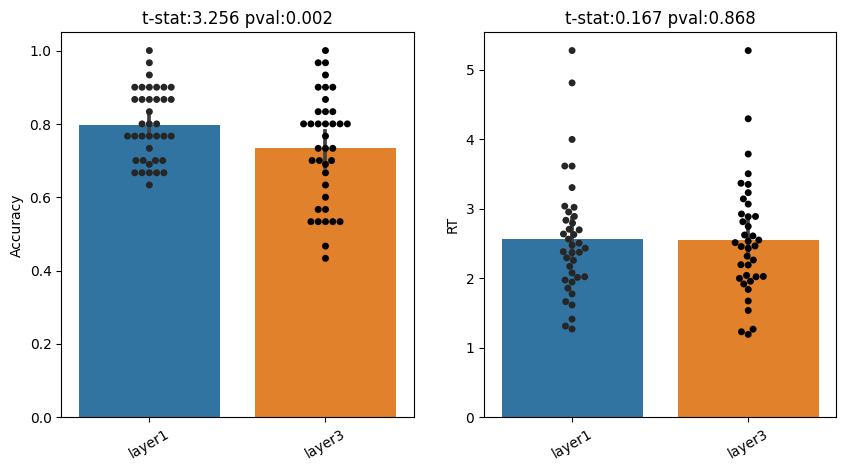

In [128]:
import scipy.stats as stats
import seaborn as sns


d1 = final_participants_df['testing_layer_1_accuracy']
d2 = final_participants_df['testing_layer_3_accuracy']
t_stat, p_value = stats.ttest_rel(d1, d2)


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')
axes[0].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_3_rt']],ax=axes[1],color='k')


d1 = final_participants_df['testing_layer_1_rt']
d2 = final_participants_df['testing_layer_3_rt']
t_stat, p_value = stats.ttest_rel(d1, d2)

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('RT')
axes[1].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')


Text(0, 0.5, 'RT')

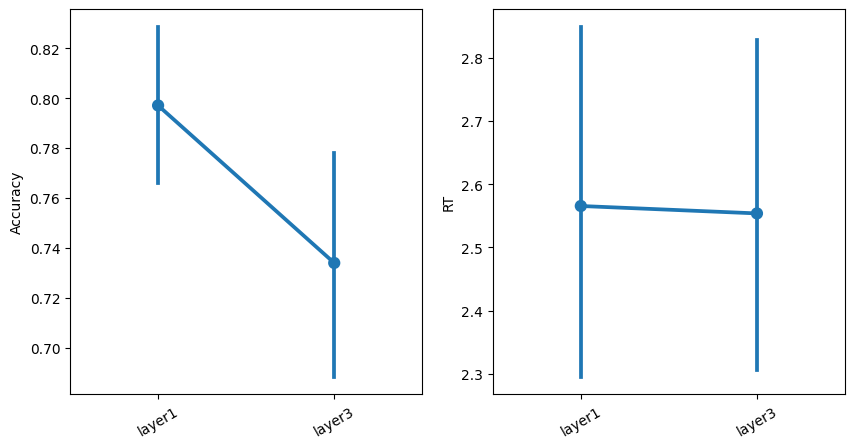

In [129]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('RT')


In [130]:

final_participants_df['worker_ID'] = final_participants_df.index
rt_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_rt','testing_layer_3_rt'],var_name='layer')

accuracy_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_accuracy','testing_layer_3_accuracy'],var_name='layer')

/var/folders/35/zj9lmn1x0ygd3qmyy6yx328w0000gn/T/ipykernel_74761/149993483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_participants_df['worker_ID'] = final_participants_df.index


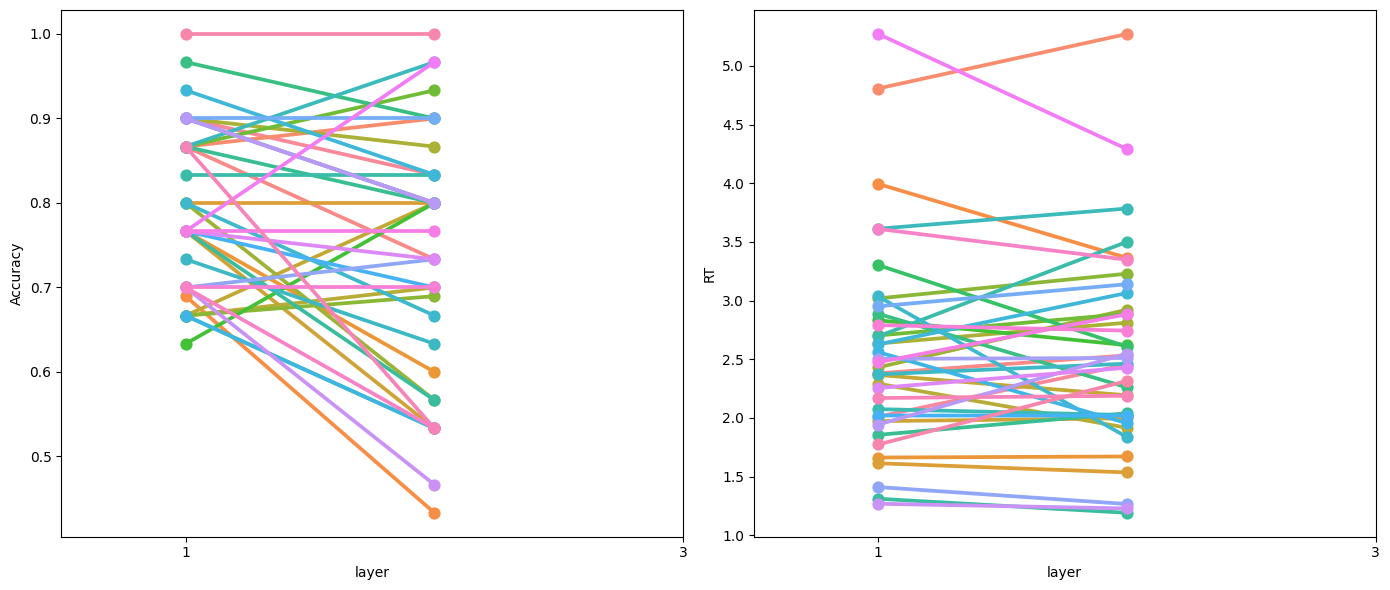

In [131]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)
#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,2],['1','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,2],['1','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

In [132]:
#this section loads the shelf dict in the state it is after finishing the testing session for this batch. 

import json
shelf_dict_after_test_name=PATH_TO_BATCH / 'shelf after session closed.txt' #define the name of the relevant shelf for this stage
with open(shelf_dict_after_test_name) as f:
    data = f.read()
shelf_dict = json.loads(data)
shelf_dict

{'A17K1CHOI773VZ': 0,
 'AMHUDJ44HF1ZH': 6,
 'AGOBQY50VQ7VX': 4,
 'A23J0G72AUTS1I': 1,
 'ATPW1MWLW7RBL': 8,
 'A12B9W69X0BQBF': 2,
 'A2RSBH1E3TEESG': 5,
 'A24GX1OZE6AY04': 3,
 'A2VO8C41JJIQY9': 7,
 'A92EMN1CW9PD7': 9,
 'AZNIEFUIVB2H0': 10,
 'A2FFCQ9WU6R764': 11,
 'A1Z8JSNPBUBCJX': 12,
 'A28HB7240OFGEW': 13,
 'A23KAJRDVCVGOE': 14,
 'A2PBFKNWWIIAO8': 15,
 'A2KLIBLDVDV144': 16,
 'A34A8MQJ7X1LCS': 17,
 'A2541C8MY0BYV3': 18,
 'ARR9GKAG3JFE5': 999,
 'A319RQYRT4C5QF': 999,
 'A2U5OFMW8H30PC': 19,
 'A34RFZEKD2D65J': 999,
 'A1XIXGOB9KUMPJ': 999,
 'A1I7H6RDJS4EKN': 22,
 'A3U3LE1CSCOZ8W': 999,
 'A3S10MQO4RXHM8': 20,
 '': 21,
 'A1I1IMZ2ROJY3I': 23,
 'AVGYS8X831LCK': 24,
 'A1ZXOJMKOXB2PP': 25,
 'A2OXC3ZQNFML9G': 25,
 'A1KRXY4629AK58': 26,
 'A19PK2894XTFEU': 999,
 'A3C5TMQP0L94K4': 28,
 'A34YNEN8UUI3CD': 29,
 'A59W78J4GX70P': 999,
 'A37JC45Y9GLSA7': 27,
 'A3V2XCDF45VN9X': 30,
 'ABVSR4GA6S3U3': 31,
 'A1OLEOOSBKCWG': 999,
 'A1PZIN8H1VI6SY': 33,
 'A2NWPE0L3EOEMV': 34,
 'A3DW6KSQPG6GVQ': 32,
 'A3U0XSWNQF05

In [133]:
# upload qualifications csv
workers_df = pd.read_csv(PATH_TO_BATCH / 'Batch_workers.csv')


In [134]:
#find all participants that exists in the shelf, and make sure they have a participantion code (so they wont be able to come back to this experiemnt)
all_shelf_workers_that_are_assigned_participantion=[]
for curr_key in shelf_dict.keys():
    if curr_key in workers_df['Worker ID'].values:
        workers_df.loc[workers_df['Worker ID']==curr_key,qualification_name_for_entire_experiment]=1
        all_shelf_workers_that_are_assigned_participantion.append(curr_key)

print(f'{len(all_shelf_workers_that_are_assigned_participantion)} were given a {qualification_name_for_entire_experiment}, names: {all_shelf_workers_that_are_assigned_participantion}')

#create a new shelf, that only contains the ids and numbers of valid participants (this is so we wont re-use thier custom trials order (csvs))
new_shelf_dict=dict()
for sub_id in final_participants_df.index: 
    sub_id = sub_id.split('_')[0]
    new_shelf_dict[sub_id]=shelf_dict[sub_id]
 

# append the final state of the last batch to the current batch for keeping all good participants 
previous_batch = 'batch ' + str(int(batch_name[-1]) - 1)
root_dirs = list(PATH_TO_BATCH.parent.iterdir())
target_dir = PATH_TO_BATCH.parent.parent / previous_batch
if target_dir in root_dirs:
    print(f'previous batch found:\n {target_dir} appending it to the shelf')
    path_final_state_shelf = target_dir / 'shelf final state.txt'
    with open(path_final_state_shelf) as f:
        data = f.read()
        shelf_dict = json.loads(data)
    
    new_shelf_dict = new_shelf_dict | shelf_dict

batch_workers_df_extended.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_workers_results_extended_with_disqualification.csv'))
workers_df.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_for_upload_after_encoding_and_test.csv'))
print('\n\ncopy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"\n')
json.dumps(new_shelf_dict)


101 were given a UPDATE-completed multicategory memory test, names: ['A17K1CHOI773VZ', 'AMHUDJ44HF1ZH', 'AGOBQY50VQ7VX', 'A23J0G72AUTS1I', 'ATPW1MWLW7RBL', 'A12B9W69X0BQBF', 'A2RSBH1E3TEESG', 'A24GX1OZE6AY04', 'A2VO8C41JJIQY9', 'A92EMN1CW9PD7', 'AZNIEFUIVB2H0', 'A2FFCQ9WU6R764', 'A1Z8JSNPBUBCJX', 'A28HB7240OFGEW', 'A23KAJRDVCVGOE', 'A2PBFKNWWIIAO8', 'A2KLIBLDVDV144', 'A34A8MQJ7X1LCS', 'A2541C8MY0BYV3', 'ARR9GKAG3JFE5', 'A2U5OFMW8H30PC', 'A1XIXGOB9KUMPJ', 'A1I7H6RDJS4EKN', 'A3S10MQO4RXHM8', 'A1I1IMZ2ROJY3I', 'AVGYS8X831LCK', 'A1ZXOJMKOXB2PP', 'A2OXC3ZQNFML9G', 'A1KRXY4629AK58', 'A3C5TMQP0L94K4', 'A34YNEN8UUI3CD', 'A37JC45Y9GLSA7', 'A3V2XCDF45VN9X', 'ABVSR4GA6S3U3', 'A1PZIN8H1VI6SY', 'A2NWPE0L3EOEMV', 'A3DW6KSQPG6GVQ', 'A3U0XSWNQF054N', 'A3CGQOJC28OVGN', 'A2V6E7SGEU0EFD', 'A2QCW55A6KZG92', 'A2RE8G7FOGBR3W', 'A12YK5TFLVVM0K', 'AC5PVOOS79W2B', 'A3TMVAECAVF9X5', 'A1VXAJIELTYK0', 'A2INGGZW5GH6RM', 'AR2K3RMWXFXWX', 'AGILQEFEPEK7N', 'A2PI9FQWMWE8J3', 'A1CX7EWQ6PBWLF', 'AXO7SR3X4HY5H', 'A1AD2BD

'{"AC5PVOOS79W2B": 43, "A1KRXY4629AK58": 26, "A1I7H6RDJS4EKN": 22, "A2PBFKNWWIIAO8": 15, "A3V2XCDF45VN9X": 30, "AEK2SAEL9GG39": 57, "A1Y6CQ2AJ882MO": 92, "AO32GL5867YY7": 55, "A22U72IVX6D0PC": 51, "ACXPNVY0QDNHR": 62, "AXO7SR3X4HY5H": 49, "A2XB75IN5BADG5": 93, "A3S10MQO4RXHM8": 20, "A140CEAA0194YY": 61, "A1UJWR5MS1ASQV": 85, "A367K74P9QF27V": 69, "A1J7C4V2AZSHQX": 66, "A23KAJRDVCVGOE": 14, "A3CGQOJC28OVGN": 36, "A1VXAJIELTYK0": 42, "AZNIEFUIVB2H0": 10, "A394S7JSNUA3TS": 71, "A2AQDPK2JTLLO2": 82, "A3E8SXH0BAYG85": 52, "A13WTEQ06V3B6D": 76, "A39KMTFHRJJASK": 75, "A2GE831IS8US6K": 86, "A28HB7240OFGEW": 13, "A2VR9O234UCT9T": 68, "A2INGGZW5GH6RM": 41, "A2M9Q0S025XT75": 94, "A2VO8C41JJIQY9": 7, "A1ZXOJMKOXB2PP": 25, "AGILQEFEPEK7N": 48, "A2V6E7SGEU0EFD": 37, "A2J4GCDXLDHYXX": 89, "A30O3RGJZZSMOE": 56, "A24GX1OZE6AY04": 3}'

# Ratings analysis 


<Axes: xlabel='layer', ylabel='bar_2.response'>

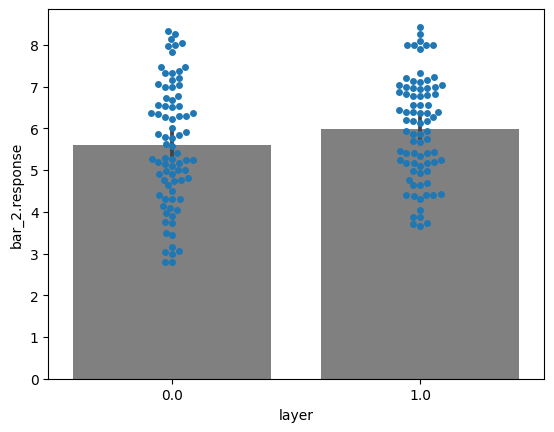

In [135]:
import seaborn as sns

# create the DataFrame
data = all_subjects_test_df.groupby(['subject','layer'])['bar_2.response'].mean().reset_index()

# plot the swarmplot and barplot on the same figure
fig, ax = plt.subplots()
sns.swarmplot(x='layer', y='bar_2.response', data=data, ax=ax)
sns.barplot(x='layer', y='bar_2.response', data=data, color='gray', ax=ax)


In [136]:
from scipy import stats

# create separate arrays for the data for each layer
layer0_data = data.loc[data['layer']==0, 'bar_2.response']
layer1_data = data.loc[data['layer']==1, 'bar_2.response']

# perform a paired t-test
t_stat, p_value = stats.ttest_rel(layer0_data, layer1_data)

# print the results
print('Paired t-test results:')
print(f't-statistic: {t_stat:.3f}')
print(f'p-value: {p_value:.3f}')

Paired t-test results:
t-statistic: -6.148
p-value: 0.000


In [137]:
#stas suggestion: for each participant calculate the averasge perceptual similarity based on the ratings vs accuracy seperastely for each distractor type: 

layer0_df_rating_accuracy = all_subjects_test_df[all_subjects_test_df['layer']==0].groupby(['subject']).aggregate({'bar_2.response':'mean','test_test_response.corr':'mean'}).corr()
display(layer0_df_rating_accuracy)

layer6_df_rating_accuracy = all_subjects_test_df[all_subjects_test_df['layer']==1].groupby(['subject']).aggregate({'bar_2.response':'mean','test_test_response.corr':'mean'}).corr()
display(layer6_df_rating_accuracy)

,bar_2.response,test_test_response.corr
bar_2.response,1.000000,-0.137081
test_test_response.corr,-0.137081,1.000000


,bar_2.response,test_test_response.corr
bar_2.response,1.000000,-0.009088
test_test_response.corr,-0.009088,1.000000


In [138]:
simillarity_df = pd.DataFrame([])
for cat in ['badlands','bridge','golf_course','highway','mountain','playground']:
    filename = f'similarity_between_pairs_VGG{cat}.csv'
    PATH_TO_PROJECT = PATH_TO_BATCH.parent.parent.parent.parent
    cur_similarity_df = pd.read_csv(PATH_TO_PROJECT/filename)
    simillarity_df = pd.concat([simillarity_df,cur_similarity_df])


simillarity_df['image1'] = simillarity_df['image1'].str.replace('.pkl','.jpg')
simillarity_df['image2'] = simillarity_df['image2'].str.replace('.pkl','.jpg')



In [139]:
# sort the values in each row
temp1 = simillarity_df[['image1', 'image2']].apply(lambda x: sorted(x)[0], axis=1)
temp2 = simillarity_df[['image1', 'image2']].apply(lambda x: sorted(x)[1], axis=1)
simillarity_df['image1']=temp1
simillarity_df['image2']=temp2

temp1 = all_subjects_test_df[['image1', 'image2']].apply(lambda x: sorted(x)[0], axis=1)
temp2 = all_subjects_test_df[['image1', 'image2']].apply(lambda x: sorted(x)[1], axis=1)
all_subjects_test_df['image1']=temp1
all_subjects_test_df['image2']=temp2

all_subjects_test_df=pd.merge(simillarity_df, all_subjects_test_df, on=['image1', 'image2'],how='right')

In [140]:

all_subjects_test_df = all_subjects_test_df.rename(columns={"test_test_response.corr": "corr", "bar_2.response": "bar_2"})
all_subjects_test_df['mean_sim']=all_subjects_test_df[[col for col in all_subjects_test_df.columns if 'level_' in col]].mean(axis=1)
all_subjects_test_df['mean_sim_0_6']=all_subjects_test_df[['level_0','level_6']].mean(axis=1)

all_subjects_test_df

,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6,model,...,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,bar_2,subject,category,mean_sim,mean_sim_0_6
0,mountain_101.jpg,mountain_171.jpg,0.663645,0.462708,0.316585,0.366748,0.291310,0.515727,0.479691,VGG,...,0.0,0.0,0.0,0.0,1.0,2.0,AC5PVOOS79W2B,mountain,0.442345,0.571668
1,mountain_232.jpg,mountain_3.jpg,0.656034,0.463188,0.356060,0.382229,0.237770,0.434647,0.419011,VGG,...,0.0,1.0,1.0,1.0,1.0,2.0,AC5PVOOS79W2B,mountain,0.421277,0.537522
2,highway_85.jpg,highway_93.jpg,0.549293,0.323910,0.239497,0.204180,0.240444,0.341033,0.316016,VGG,...,0.0,2.0,2.0,2.0,1.0,4.0,AC5PVOOS79W2B,highway,0.316339,0.432654
3,mountain_123.jpg,mountain_94.jpg,0.478399,0.371338,0.243143,0.167504,0.158210,0.305985,0.207915,VGG,...,0.0,3.0,3.0,3.0,1.0,1.0,AC5PVOOS79W2B,mountain,0.276070,0.343157
4,golf_course_209.jpg,golf_course_309.jpg,0.277926,0.271246,0.218506,0.169659,0.105549,0.433722,0.587891,VGG,...,0.0,4.0,4.0,4.0,1.0,3.0,AC5PVOOS79W2B,golfcourse,0.294929,0.432909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,golf_course_217.jpg,golf_course_262.jpg,0.268017,0.286801,0.206212,0.199519,0.196874,0.521599,0.684805,VGG,...,0.0,55.0,55.0,55.0,1.0,3.0,A24GX1OZE6AY04,golfcourse,0.337690,0.476411
4796,badlands_24.jpg,badlands_3.jpg,0.474635,0.374899,0.295967,0.279708,0.225719,0.373287,0.308845,VGG,...,0.0,56.0,56.0,56.0,1.0,2.0,A24GX1OZE6AY04,badlands,0.333294,0.391740
4797,highway_273.jpg,highway_384.jpg,0.613053,0.392409,0.304938,0.328729,0.351532,0.583315,0.542290,VGG,...,0.0,57.0,57.0,57.0,1.0,3.0,A24GX1OZE6AY04,highway,0.445181,0.577672
4798,highway_174.jpg,highway_415.jpg,0.282304,0.237405,0.199127,0.169243,0.217185,0.575302,0.740489,VGG,...,0.0,58.0,58.0,58.0,1.0,4.0,A24GX1OZE6AY04,highway,0.345865,0.511396


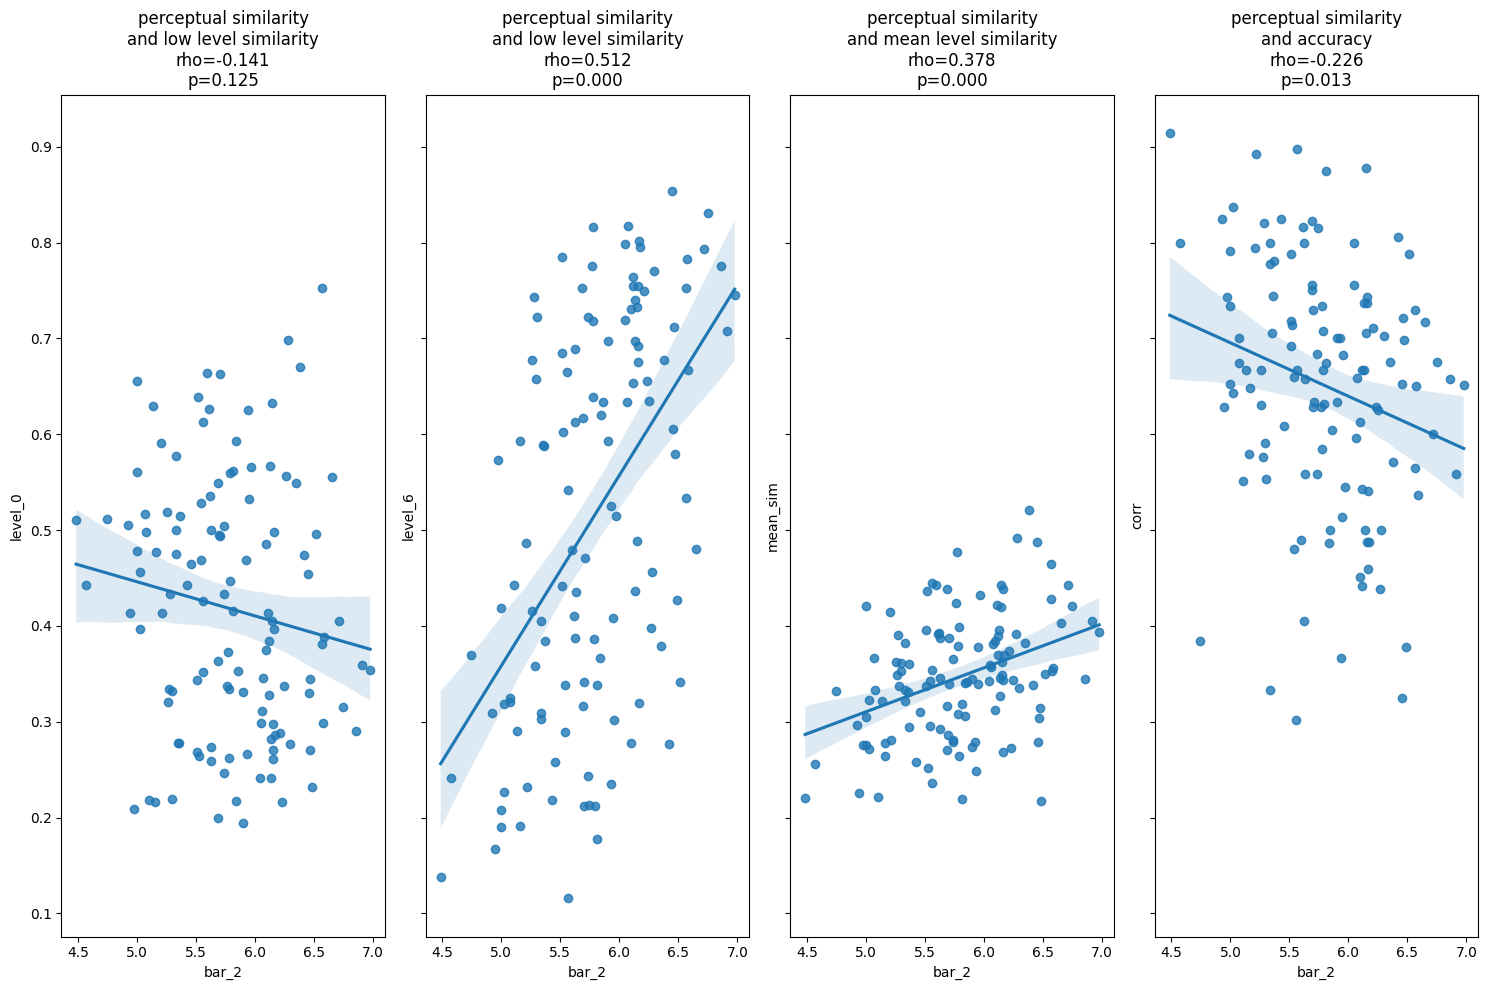

In [141]:
correlations_df=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'})

fig,axes=plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(15,10))
sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean'}),x='bar_2',y='level_0',ax=axes[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['bar_2'], y=correlations_df['level_0'])
axes[0].set_title(f'perceptual similarity\nand low level similarity\nrho={r_value:.3f}\np={p_value:.3f}')

sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean'}),x='bar_2',y='level_6',ax=axes[1])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['bar_2'], y=correlations_df['level_6'])
axes[1].set_title(f'perceptual similarity\nand low level similarity\nrho={r_value:.3f}\np={p_value:.3f}')


sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean'}),x='bar_2',y='mean_sim',ax=axes[2])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['bar_2'], y=correlations_df['mean_sim'])
axes[2].set_title(f'perceptual similarity\nand mean level similarity\nrho={r_value:.3f}\np={p_value:.3f}')


sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'}),x='bar_2',y='corr',ax=axes[3])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['bar_2'], y=correlations_df['corr'])
axes[3].set_title(f'perceptual similarity\nand accuracy\nrho={r_value:.3f}\np={p_value:.3f}')
fig.tight_layout()

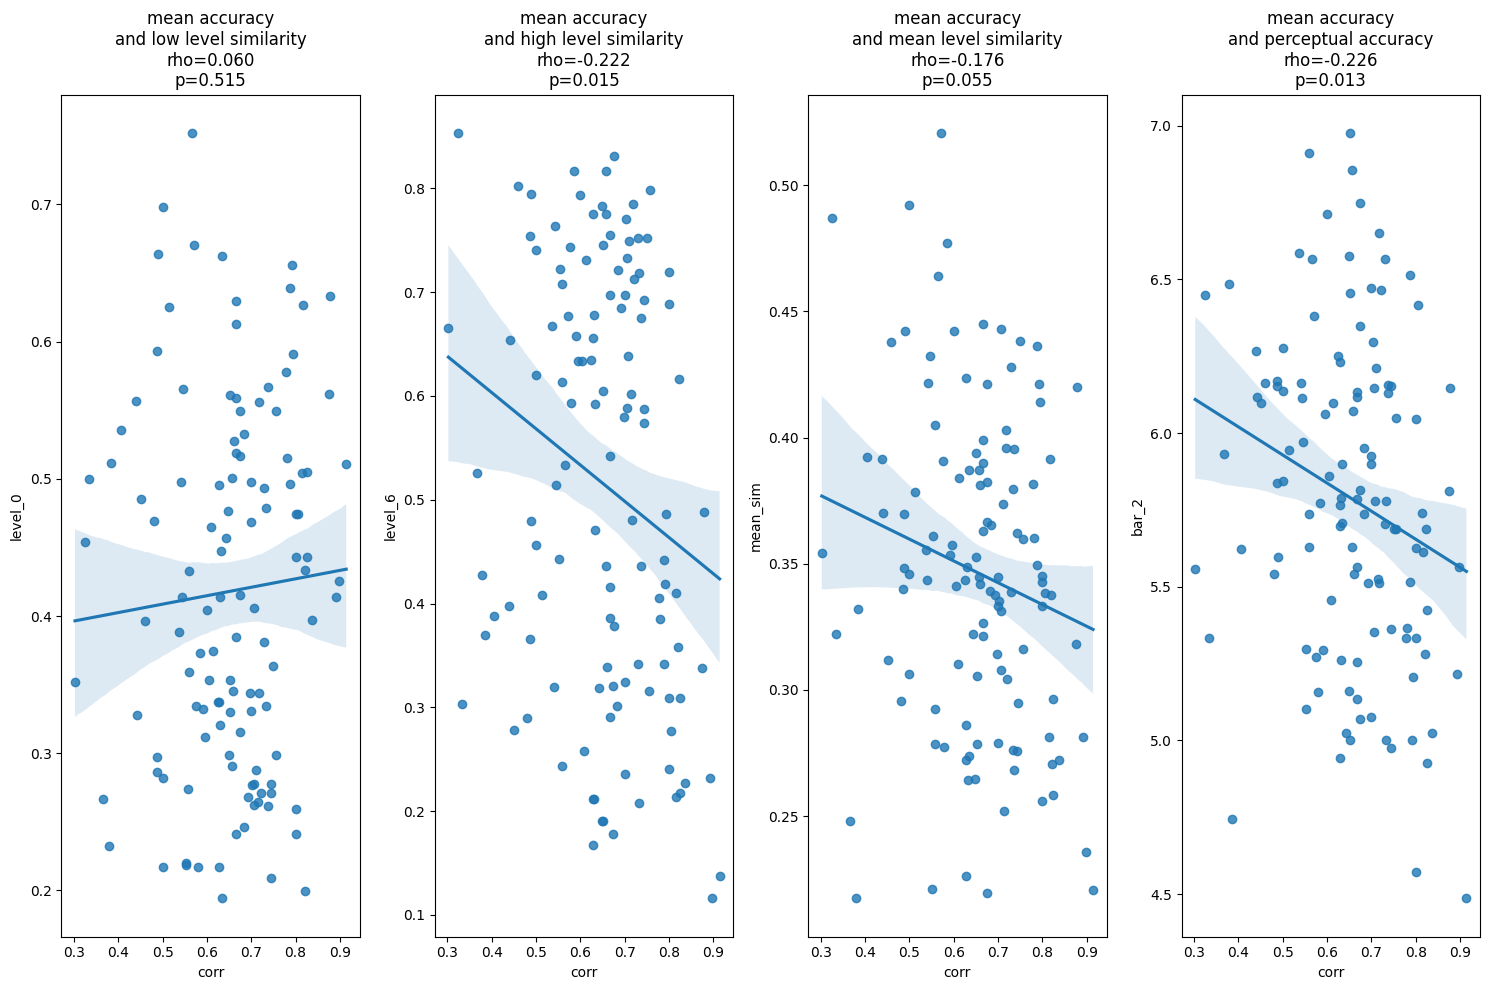

In [142]:
correlations_df=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'})

fig,axes=plt.subplots(nrows=1,ncols=4,figsize=(15,10))
sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'}),x='corr',y='level_0',ax=axes[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['corr'], y=correlations_df['level_0'])
axes[0].set_title(f'mean accuracy\nand low level similarity\nrho={r_value:.3f}\np={p_value:.3f}')

sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'}),x='corr',y='level_6',ax=axes[1])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['corr'], y=correlations_df['level_6'])
axes[1].set_title(f'mean accuracy\nand high level similarity\nrho={r_value:.3f}\np={p_value:.3f}')


sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'}),x='corr',y='mean_sim',ax=axes[2])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['corr'], y=correlations_df['mean_sim'])
axes[2].set_title(f'mean accuracy\nand mean level similarity\nrho={r_value:.3f}\np={p_value:.3f}')


sns.regplot(data=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'}),x='corr',y='bar_2',ax=axes[3])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=correlations_df['corr'], y=correlations_df['bar_2'])
axes[3].set_title(f'mean accuracy\nand perceptual accuracy\nrho={r_value:.3f}\np={p_value:.3f}')
fig.tight_layout()

In [143]:

temp_correlations_df=all_subjects_test_df.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean','mean_sim_0_6':'mean'})
temp_correlations_df.corr()

,bar_2,level_0,level_6,mean_sim,corr,mean_sim_0_6
bar_2,1.000000,-0.140839,0.511556,0.378296,-0.225847,0.501268
level_0,-0.140839,1.000000,-0.554877,0.386426,0.060058,0.115222
level_6,0.511556,-0.554877,1.000000,0.489540,-0.221998,0.762458
mean_sim,0.378296,0.386426,0.489540,1.000000,-0.175811,0.885062
corr,-0.225847,0.060058,-0.221998,-0.175811,1.000000,-0.218358
mean_sim_0_6,0.501268,0.115222,0.762458,0.885062,-0.218358,1.000000


In [144]:
all_subjects_test_df[all_subjects_test_df['layer']==0]

,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6,model,...,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,bar_2,subject,category,mean_sim,mean_sim_0_6
0,mountain_101.jpg,mountain_171.jpg,0.663645,0.462708,0.316585,0.366748,0.291310,0.515727,0.479691,VGG,...,0.0,0.0,0.0,0.0,1.0,2.0,AC5PVOOS79W2B,mountain,0.442345,0.571668
1,mountain_232.jpg,mountain_3.jpg,0.656034,0.463188,0.356060,0.382229,0.237770,0.434647,0.419011,VGG,...,0.0,1.0,1.0,1.0,1.0,2.0,AC5PVOOS79W2B,mountain,0.421277,0.537522
2,highway_85.jpg,highway_93.jpg,0.549293,0.323910,0.239497,0.204180,0.240444,0.341033,0.316016,VGG,...,0.0,2.0,2.0,2.0,1.0,4.0,AC5PVOOS79W2B,highway,0.316339,0.432654
3,mountain_123.jpg,mountain_94.jpg,0.478399,0.371338,0.243143,0.167504,0.158210,0.305985,0.207915,VGG,...,0.0,3.0,3.0,3.0,1.0,1.0,AC5PVOOS79W2B,mountain,0.276070,0.343157
5,golf_course_130.jpg,golf_course_87.jpg,0.626775,0.391973,0.272313,0.262062,0.273848,0.502944,0.409988,VGG,...,0.0,5.0,5.0,5.0,1.0,7.0,AC5PVOOS79W2B,golfcourse,0.391415,0.518382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,highway_85.jpg,highway_93.jpg,0.549293,0.323910,0.239497,0.204180,0.240444,0.341033,0.316016,VGG,...,0.0,51.0,51.0,51.0,1.0,3.0,A24GX1OZE6AY04,highway,0.316339,0.432654
4792,golf_course_157.jpg,golf_course_188.jpg,0.456735,0.361695,0.272871,0.266913,0.212053,0.366717,0.318765,VGG,...,0.0,52.0,52.0,52.0,1.0,2.0,A24GX1OZE6AY04,golfcourse,0.322250,0.387750
4794,playground_137.jpg,playground_144.jpg,0.425595,0.335114,0.247312,0.183824,0.141902,0.201654,0.115837,VGG,...,0.0,54.0,54.0,54.0,1.0,2.0,A24GX1OZE6AY04,playground,0.235891,0.270716
4796,badlands_24.jpg,badlands_3.jpg,0.474635,0.374899,0.295967,0.279708,0.225719,0.373287,0.308845,VGG,...,0.0,56.0,56.0,56.0,1.0,2.0,A24GX1OZE6AY04,badlands,0.333294,0.391740


<Axes: >

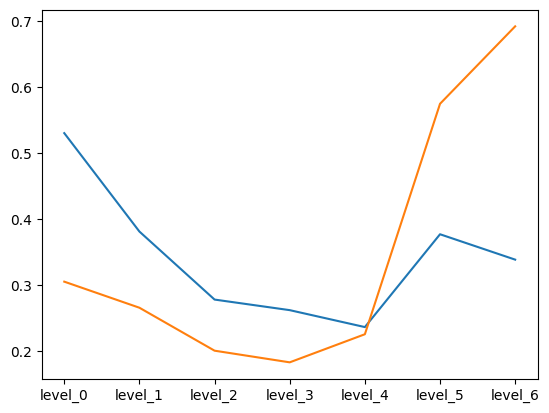

In [145]:
#could probably be deleted: just another quick check of how the similarity profiles look across the network 

all_subjects_test_df[all_subjects_test_df['layer']==0].groupby(['image1','image2']).aggregate({'level_0':'mean',
                                                             'level_1':'mean',
                                                             'level_2':'mean',
                                                             'level_3':'mean',
                                                             'level_4':'mean',
                                                             'level_5':'mean',
                                                             'level_6':'mean'}).mean(axis=0).plot()

all_subjects_test_df[all_subjects_test_df['layer']==1].groupby(['image1','image2']).aggregate({'level_0':'mean',
                                                             'level_1':'mean',
                                                             'level_2':'mean',
                                                             'level_3':'mean',
                                                             'level_4':'mean',
                                                             'level_5':'mean',
                                                             'level_6':'mean'}).mean(axis=0).plot()

In [146]:
model=sm.OLS(correlations_df[['bar_2']],sm.add_constant(correlations_df[['level_0','level_6']])).fit()
print(model.summary())

model1=sm.OLS(correlations_df[['bar_2']],sm.add_constant(correlations_df[['level_6']])).fit()
print(model1.summary())

model2=sm.OLS(correlations_df[['bar_2']],sm.add_constant(correlations_df[['level_0']])).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  bar_2   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     24.04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           1.80e-09
Time:                        13:57:59   Log-Likelihood:                -72.192
No. Observations:                 120   AIC:                             150.4
Df Residuals:                     117   BIC:                             158.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6180      0.250     18.507      0.0

In [147]:
model=sm.OLS(correlations_df[['corr']],sm.add_constant(correlations_df[['level_0','level_6']])).fit()
print(model.summary())

model1=sm.OLS(correlations_df[['corr']],sm.add_constant(correlations_df[['level_6']])).fit()
print(model1.summary())

model2=sm.OLS(correlations_df[['corr']],sm.add_constant(correlations_df[['level_0']])).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   corr   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.407
Date:                Wed, 28 Jun 2023   Prob (F-statistic):             0.0364
Time:                        13:57:59   Log-Likelihood:                 78.356
No. Observations:                 120   AIC:                            -150.7
Df Residuals:                     117   BIC:                            -142.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7779      0.071     10.931      0.0

<Axes: >

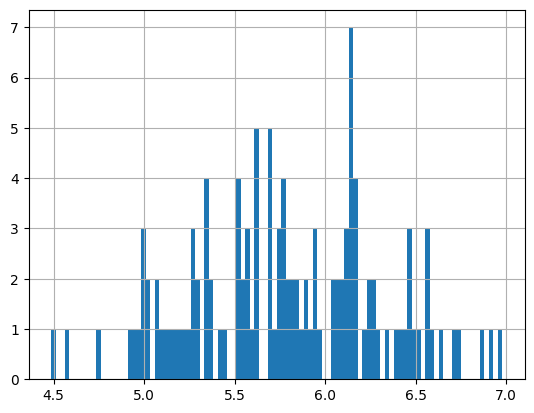

In [148]:
correlations_df['bar_2'].hist(bins=100)

In [149]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fit the mixed-effects logistic regression model
model = smf.mixedlm("corr ~ bar_2", all_subjects_test_df, groups=all_subjects_test_df["subject"])


result = model.fit()

# print the model summary
print(result.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: corr      
No. Observations: 4800    Method:             REML      
No. Groups:       80      Scale:              0.2028    
Min. group size:  60      Log-Likelihood:     -3072.3540
Max. group size:  60      Converged:          Yes       
Mean group size:  60.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.690    0.032 21.244 0.000  0.626  0.753
bar_2         -0.007    0.005 -1.425 0.154 -0.016  0.002
Group Var      0.024    0.010                           



In [150]:
model_0 = smf.mixedlm("corr ~ bar_2 + C(layer)", all_subjects_test_df.query("layer == 0"), groups=all_subjects_test_df.query("layer == 0")["subject"])
result_0 = model_0.fit()

model_1 = smf.mixedlm("corr ~ bar_2 + C(layer)", all_subjects_test_df.query("layer == 1"), groups=all_subjects_test_df.query("layer == 1")["subject"])
result_1 = model_1.fit()

print("Results for layer 0:")
print(result_0.summary())




Results for layer 0:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: corr      
No. Observations: 2400    Method:             REML      
No. Groups:       80      Scale:              0.1962    
Min. group size:  30      Log-Likelihood:     -1518.1923
Max. group size:  30      Converged:          Yes       
Mean group size:  30.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.728    0.039 18.599 0.000  0.651  0.805
bar_2         -0.010    0.006 -1.571 0.116 -0.021  0.002
Group Var      0.023    0.011                           



In [151]:
print("Results for layer 1:")
print(result_1.summary())

Results for layer 1:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: corr      
No. Observations: 2400    Method:             REML      
No. Groups:       80      Scale:              0.2087    
Min. group size:  30      Log-Likelihood:     -1592.7202
Max. group size:  30      Converged:          Yes       
Mean group size:  30.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.643    0.045 14.333 0.000  0.555  0.731
bar_2         -0.002    0.007 -0.363 0.717 -0.016  0.011
Group Var      0.025    0.011                           

